# Фильтрация координат, полученных с GPS от шумов

Суть задачи в подробностях описана на [github](https://github.com/nextgis/android_gisapp/issues/65). Ниже дается краткая сводка:
 * GPS выдает координаты с шумами. Требуется отфильтровать данные так, чтобы шумы по возможности были удалены последовательности координат. Это можно сделать, исходя из соображений, что устройство двигается  более-менее ровно, без резких скачков.
 
## Вводим обозначения и терминологию

Путь координаты приемника поступают с него последовательно в моменты времени  $t=t_i$ ($i=0, 1, \dots$).

Пусть на момент времени $t=t_i$ нам известны все предыдущие замеры координат:

$$\Big(\big(x(t_0), y(t_0)\big), \big(x(t_1), y(t_1)\big), \dots \big(x(t_{i-1}), y(t_{i-1})\big)\Big).$$ 

Требуется построить алгоритм, который, имея на входе значения координат за прошлые моменты времени  

$$\big(\big(x(t_0), y(t_0)\big), \big(x(t_1), y(t_1)\big), \dots \big(x(t_{i-1}), y(t_i)\big)\big)$$

и вновь поступающую пару координат $\big(x(t_i), y(t_i) \big)$,  вычисляет их сглаженные значения $\big(s_x(t_{i}), s_y(t_i)\big)$, формируя последовательность сглаженных координат 

$$\big(\big(s_x(t_0), s_y(t_0)\big), \big(s_x(t_1), s_y(t_1)\big), \dots \big(s_x(t_{i-1}), s_y(t_{i-1})\big), \big(s_x(t_{i}), s_y(t_i)\big)\big).$$ 

В этой формулировке не дается определения термину "сглаженная последовательность". Формальное определение термину дать сложно, поскольку в разных задачах подразумевается разные "сглаживания". Поэтому сглаживание определим больше описательно, чем формально. Итак, сглаживание должно обеспечивать создание такой результирующей линии, которая:

 1. не содержит больших и резких скачков в координатах;
 2. не слишком удаляется от точек, выданных приемником GPS.

Условие 1) в общем случае противоречит условию 2): если приемник выдает очень шумные координаты, то пользователь ожидает, что сглаженная линия будет проходить где-то по середине облака точек координат, а это автоматически означает отдаленность от наиболее зашумленных точек.

**Отсутствие четкой формулировки того, что считать "сглаживанием" приводит к тому, что нет четкого критерия хорошо сглажена итоговая линия или нет.**

## Первый взгляд на данные

Импортируем необходимые библиотеки, произведем подготовительные настройки:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [15, 10]

Читаем данные из БД, отобразим первые несколько записей в табличном виде:

In [3]:
con = sqlite3.connect("data/layers.db")
points = pd.read_sql_query("SELECT * from trackpoints order by time", con)

points.head()

,lon,lat,ele,fix,sat,time,session
0,4.175275e+06,7.466747e+06,179.0,3d,0,1524724750000,1
1,4.175293e+06,7.466724e+06,0.0,3d,0,1524724758673,1
2,4.175289e+06,7.466731e+06,189.0,3d,12,1524724768000,1
3,4.175286e+06,7.466711e+06,188.0,3d,8,1524724776000,1
4,4.175235e+06,7.466715e+06,0.0,3d,13,1524724778719,1


Построим график того, как меняется широта с течением времени. Видны "зубчики" - вероятные выбросы/погрешности измерений:

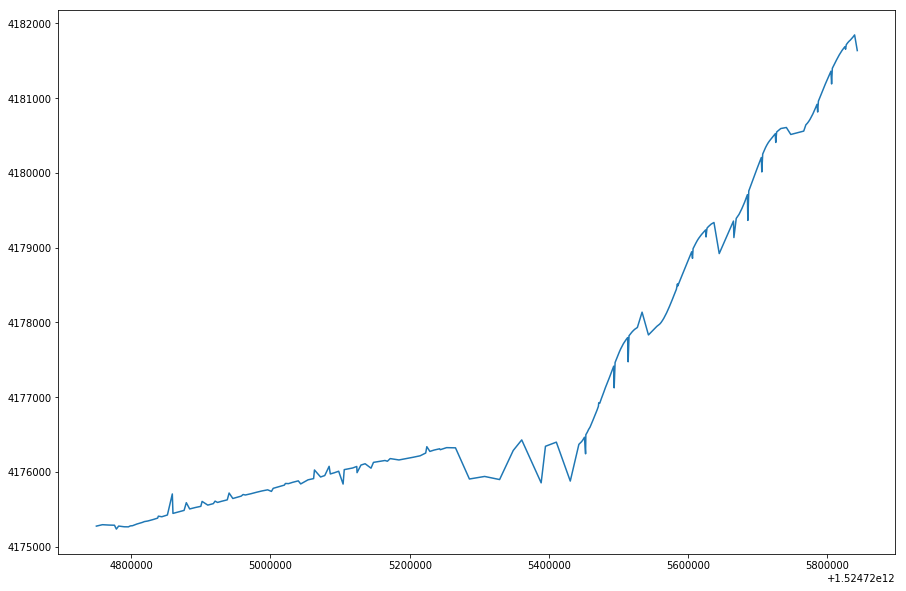

In [4]:
plt.plot(points.time, points.lon)

Построим график того, как меняется долгота с течением времени, видим, что ситуация аналогичная:

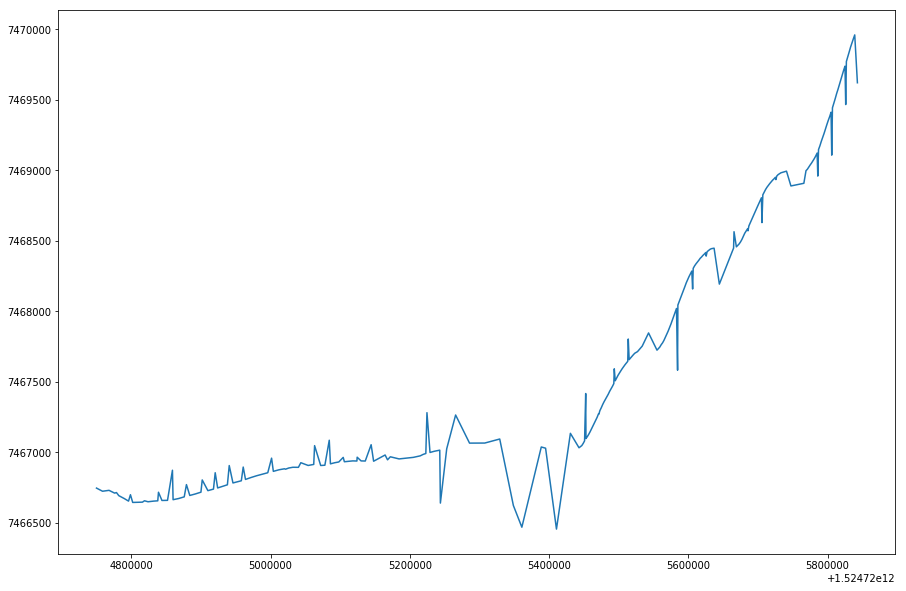

In [5]:
plt.plot(points.time, points.lat)

График траектории в географическом пространстве:

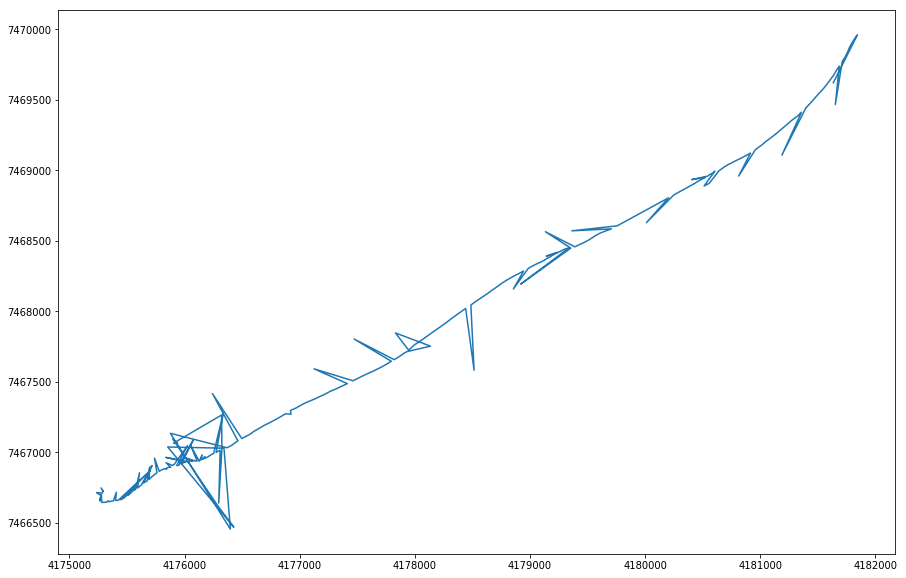

In [6]:
plt.plot(points.lon, points.lat)

Выкинем явно ошибочные точки (точки с нулевой высотой):

In [7]:
points = pd.read_sql_query("SELECT * from trackpoints where ele>0  order by time", con)
points.head()

,lon,lat,ele,fix,sat,time,session
0,4.175275e+06,7.466747e+06,179.0,3d,0,1524724750000,1
1,4.175289e+06,7.466731e+06,189.0,3d,12,1524724768000,1
2,4.175286e+06,7.466711e+06,188.0,3d,8,1524724776000,1
3,4.175275e+06,7.466693e+06,185.0,3d,9,1524724782000,1
4,4.175266e+06,7.466672e+06,185.0,3d,15,1524724790000,1


Строим аналогичные графики:

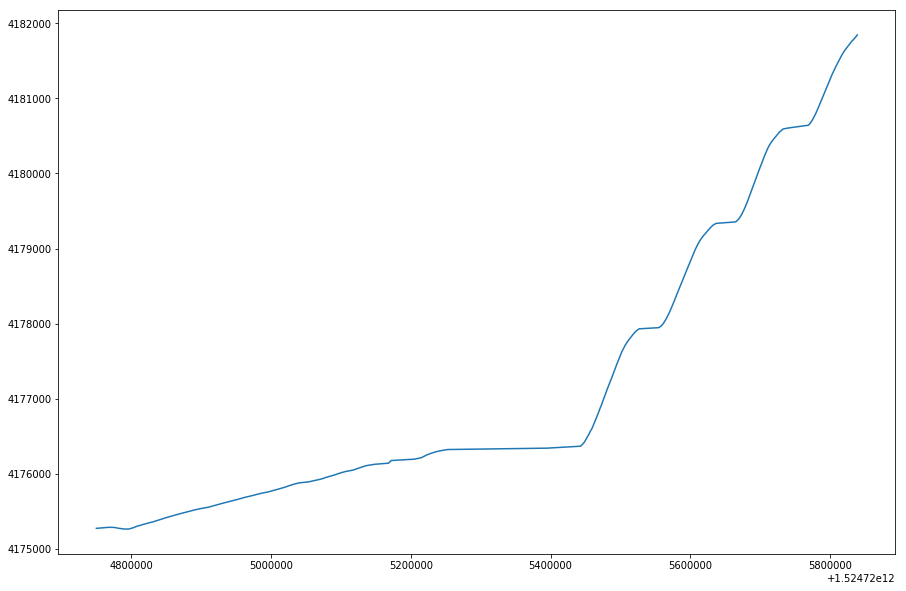

In [8]:
plt.plot(points.time, points.lon)

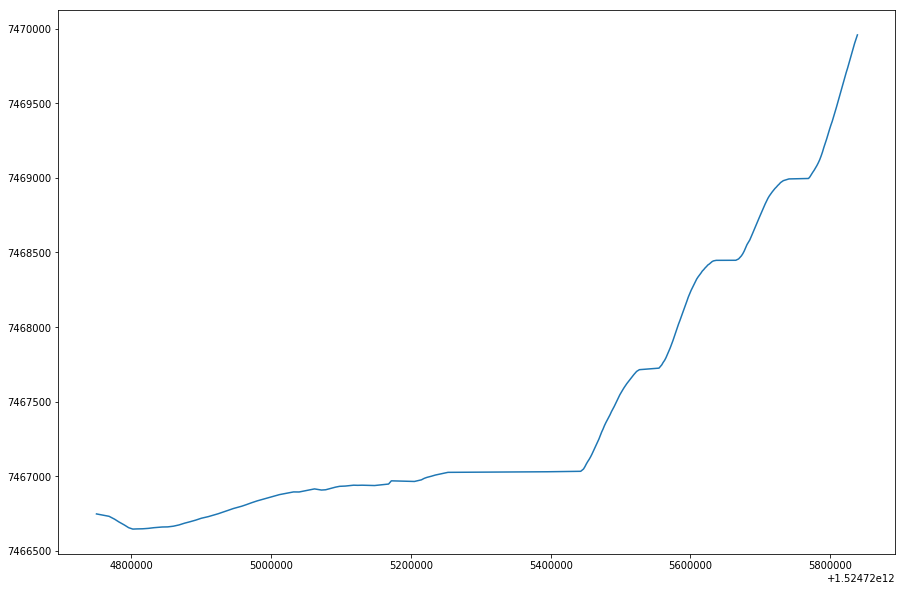

In [9]:
plt.plot(points.time, points.lat)

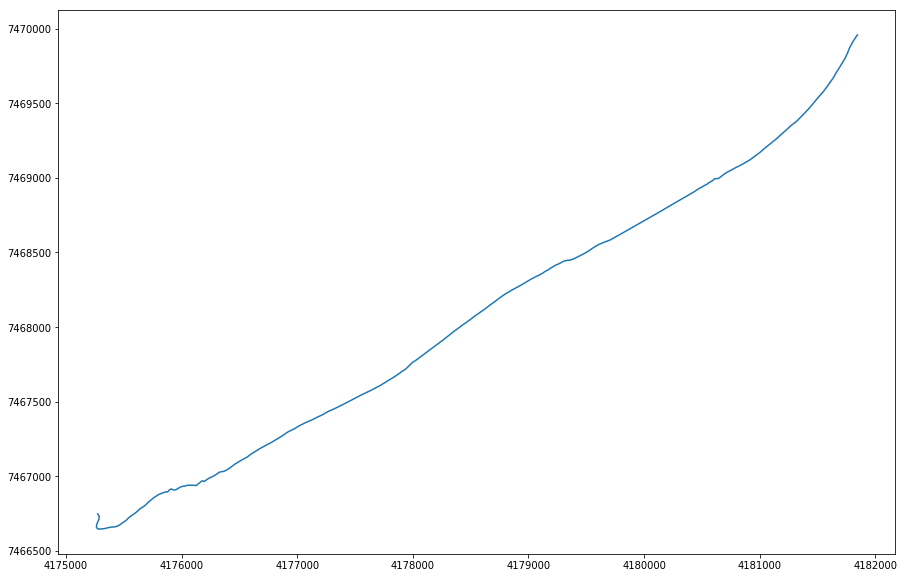

In [10]:
plt.plot(points.lon, points.lat)

Ух... попался "хороший" заезд, весь мусор в данных фильтруется по высоте. Алгоритмы сглаживания лучше проверять на несколько худших данных, чем эти.

## Фильтрация данных

### Вводные замечания

Для того, чтобы проверить разные способы фильтрации, нам нужны "плохие" данные для экспериментов. Поэтому будем фильтровать исходные данные, а не те из которых были удалены явно ошибочные точки.

In [11]:
points = pd.read_sql_query("SELECT * from trackpoints  order by time", con)

In [12]:
t = np.array(points.time)
x = np.array(points.lon)
y = np.array(points.lat)

В начальный момент времени и координаты, и время уже содержат большие по модулю значения. Эти значения могут вызвать переполнение разрядной сетки или снизить точность вычислений. Поэтому при расчетах из данных будем вычитать начальные значения (т.е. координаты и время первой измеренной точки).

In [13]:
t0 = t[0]
x0 = x[0]
y0 = y[0]

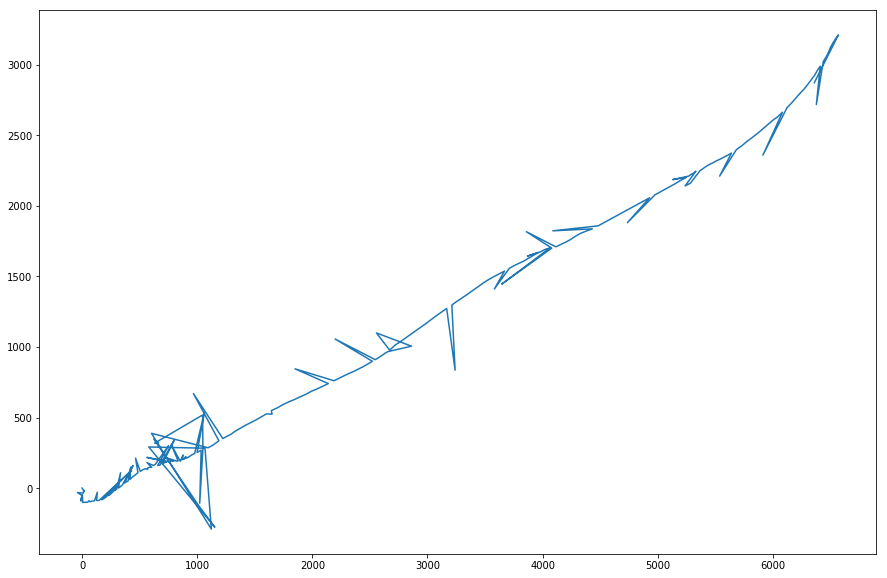

In [14]:
plt.plot(x - x0, y - y0)

### Сглаживание координат x и y независимо друг от друга

Для простоты процесса начнем с того, что будем сглаживать каждую координату x и y независимо друг от друга.

#### Экспоненциальное сглаживание

Начнем с первого, что приходит в голову - [экспоненциальное сглаживание](http://www.machinelearning.ru/wiki/index.php?title=%D0%AD%D0%BA%D1%81%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%81%D0%B3%D0%BB%D0%B0%D0%B6%D0%B8%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5). Формула для рассчетов:
$$
s(t_i) = \alpha x(t_i) + (1- \alpha) s(t_{i-1}).
$$

В этой формуле фигурирует параметр $\alpha\in [0,1]$, который контролирует величину сглаживания: чем ближе его значение к единице, тем больше сглаженная величина будет "похожа" на $x(t)$, сотвественно, при $\alpha \approx 0$ вновь поступающая координата влияет на сглаженную величину незначительно, и траектория сглаженной линии "двигается по инерции".

Нужно сразу сделать оговорку, что в формуле подразумевается, что замеры производятся через равные промежутки времени. На самом деле наши координаты измеряются через неравные интервалы и формулу нужно модифицировать. Но для прикидок оставим ее.

Закодируем формулу в виде функции:

In [15]:
def next_point(x, s_prev, a=0.7):
    return a*x + (1-a) * s_prev

Прогоним процедуру сглаживания для координаты x. Начнем с x0 и будем подавать по одному новому значению. По предыдущим значениям сглаженной линии и вновь поступающей координате получим новое значение для сглаженной координаты:

In [16]:
a = 0.3
filtered = [x0 - x0]
for val in x[1:]:
    new = next_point(val-x0, filtered[-1], a)
    filtered.append(new)
s1 = np.array(filtered)

Отобразим на графике исходную координату и сглаженную:

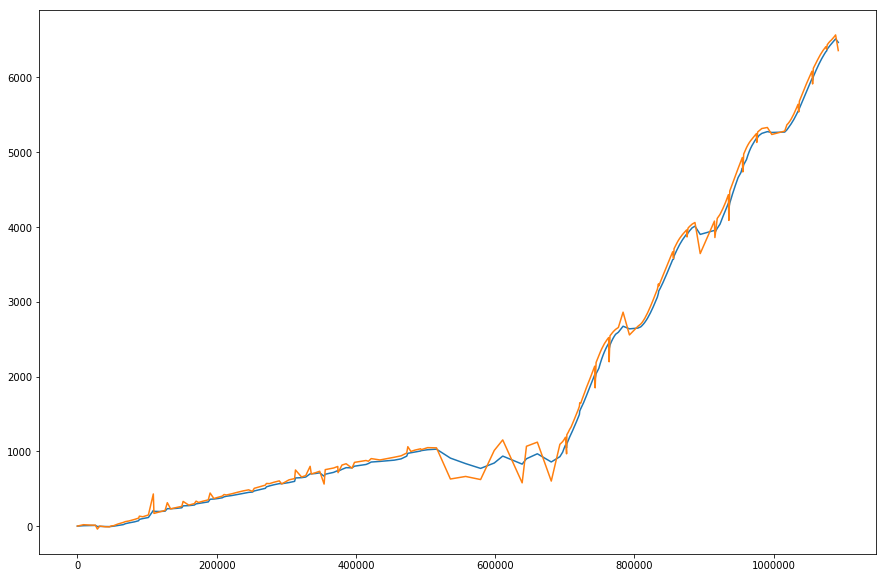

In [17]:
plt.plot(t - t0, s1, t - t0, x-x0)

Аналогичным образом сгладим координату y и построим график для этой координаты:

In [18]:
a = 0.3
filtered = [y0 - y0]
for val in y[1:]:
    new = next_point(val-y0, filtered[-1], a)
    filtered.append(new)
s2 = np.array(filtered)

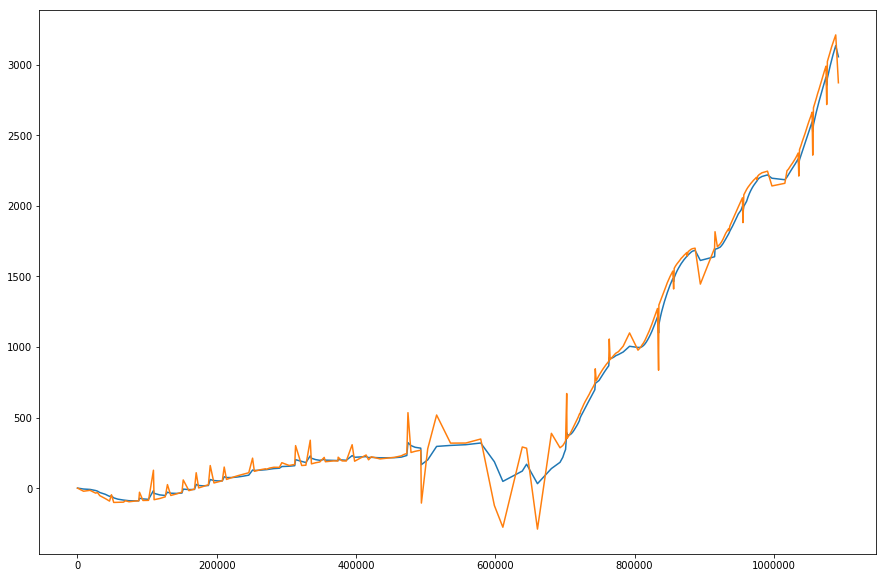

In [19]:
plt.plot(t - t0, s2, t - t0, y-y0)

Отобразим на графике исходную траекторию приемника в географическом пространстве и сглаженную траекторию.

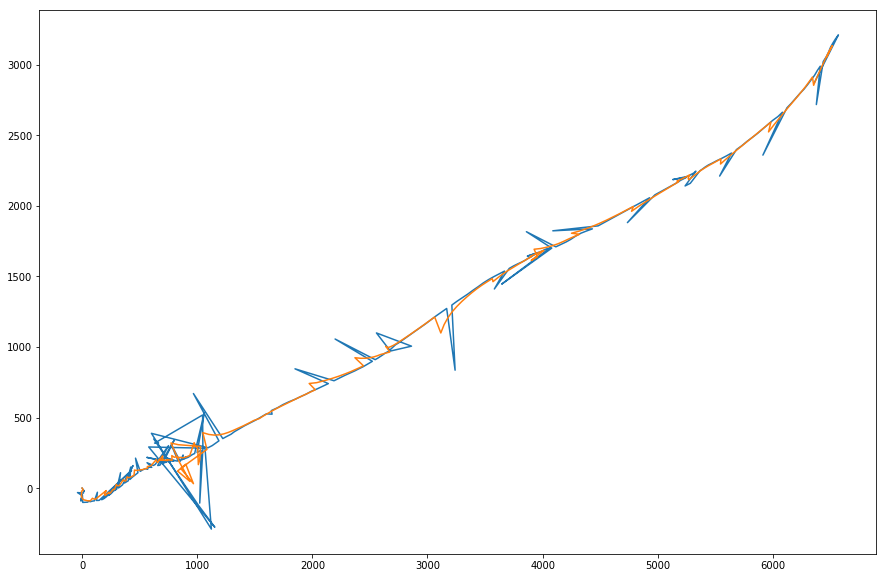

In [20]:
plt.plot(x - x0, y - y0, s1, s2)

Видим, что шумы уменьшились, но все равно остались. Если уменьшить $\alpha$, то получим более сглаженную линию.

##### Вывод

Способ должен сработать для не слишком сильных шумов. Например, если данные предварительно очистить от явного мусора, то скорее всего этого хватит.

Для того, чтобы способ сработал, нужно подбирать параметр $\alpha$ под кривую: чем больше шумов в кривой, тем более жестким должен быть этот параметр. Проблема такого подхода в том, что $\alpha$ задается один раз и сразу для всей кривой, при этом на одной и той же кривой могут быть как "хорошие", так и "плохие" участки, поэтому вряд ли существует $\alpha$, пригодный сразу для всех кривых.

Таким образом:
 * экспоненциальное сглаживание и постоянной величине $\alpha$ должно сработать, при небольших шумах;
 * при наличии на траектории участков разной сложности, потребуется усложнить функцию фильтрации, в частности выбирать $\alpha$ различным для различных точек траектории. Преспективным кажется подход, когда сглаживание в точке зависит от того, насколько данная точка похожа на "настоящую", т.е. от величины шумов в данной точке: чем больше шум, тем меньше должно быть значение $\alpha$. Как следствие, потребуется оценка того, насколько данная точка искажена шумом.

### Сглаживание на основе матмодели

В этом разделе попробуем подобрать величину сглаживания в зависимости от величины шумов. Для этого обратимся к математической модели движения GPS-приемника. Рассматриваются два варианта:
 1. Движение приемника происходит в пешем режиме.
 2. Движение происходит на автотранспорте.
 
В этих случаях на изменения координат можно наложить ограничения: ни человек, ни автомобиль не могут менять свои координаты слишком резко. Поэтому, чем более резкие изменения в траектории происходят, тем более вероятно, что эти изменения вносятся погрешностями измерения координат, а не реальным движением приемника.

Также понятно, что в случае движения автомобиля возможны более высокие скорости движения и как следствие, более быстрые изменения координат, поэтому ниже ограничимся анализом одного случая - движения на автомобиле.

#### Теория
В этом разделе рассматривается вопрос сглаживания данных исходя из того, что получаемые координаты - это координаты физического объекта, движущегося в физическом пространстве.

Как следствие, вектор координат $r(t) = (x(t), y(t))$ приемника должны подчиняться уравнениям движения:

$$
r(t) = \int_{t_0}^{t} v(s) ds, \qquad v(t) = \int_{t_0}^{t} a(s) ds,
$$

где $v(t)$ - вектор скорости, а $a(t)$ - вектор ускорения.

При этом исходя из самых общих соображений понятно, что скорость и ускорение должны быть ограничены по модулю. Значит, если наши данные показывают, что в неторой точке скорость или ускорение превысили некий разумный порог, то данные для этой точки некорректны.

Воспрос состоит в том, каковы должны быть эти пороги. Ограничение на скорость более-менее очевидны: 150 км/час - это уже близко к верхней границе. Ограничения на ускорение требует отдельного рассмотрения.

Интернет говорит о том, что существуют матмодели, описывающие механику ускорений движущегося автомобиля, например, согласно [В.В. Селифонов, А.Ш. Хусаинов, В.В. Ломакин. ТЕОРИЯ АВТОМОБИЛЯ.](http://mospolytech.ru/storage/files/kaf/auto/books/94.pdf) ускорение $j$ автомобиля рассчитывается по следующей формуле (при условии движения по горизонтальной поверхности):
$$
j = \frac{D - \psi}{\delta_{\text{вр}}} g,
$$
где $D$  - динамический фактор, $\psi$ - коффициент сопротивления дороги, $\delta_{\text{вр}}$ - коэффициент учета вращающихся масс автомобиля (он зависит от передаточного числа $u$ коробки передач: $\delta_{\text{вр}} \approx 1 + 0.005(1+u^2)$). Проблема в том, что для каждого типа автомобиля и коробки передач получаются свои значения.

По идее мы можем посчитать на основе имеющихся координат за прошедший период времени оценки для этих неизвестных значений, но у нас нет задачи построения матмодели транспортного средства, на котором стоит датчик. Поэтому воспользуемся грубыми прикидками. Если прикидки не дадут оценок, достаточных для качественной фильтрации шумов, вернемся к вопросу построения полной матмодели.

Глядя на формулу для ускорения $j$ видим, что **возможное максимальное ускорение тем выше, чем ниже передача** (и соотвественно, скорость), то есть на больших передачах невозможны большие ускорения автомобиля. В частности, [типичный график зависимости ускорения автомобиля от скорости и передачи](https://studfiles.net/html/2706/502/html_qoSIgogKcX.7hyC/img-0Kc2YO.png).

Интернет дает такие диапазоны максимальный ускорений $j$ в зависимости от вида транспорта:

тип      | максимальные значения $j$
---------|--------------------------
легковые | 2.0 - 2.5 м/с^2
грузовые | 1.7 - 2.0 м/с^2
автобусы | 1.6 - 1.8 м/с^2

##### Правила фильтрации

Таким образом мы получаем следующие правила:

 * Если скорость автомобиля в точке превышает порог (условно 150 км/ч ~ 41.7 м/с) - считаем эту точку выбросом;
 * Если ускорение автомобиля в точке превышает порог (условно 2.5 м/с^2) - считаем эту точку выбросом;
 * Если величина ускорения в точке находится в районе максимально возможной (условно, 1.7 м/с^2 и выше), а скорость средняя или выше (условно > 50 км/ч) - считаем эту точку выбросом.

##### Рассчет скоростей и ускорений

Для того, чтобы получить скорости и ускорения из наших данных, нужно произвести численное дифференцирование соответствующих формул, тогда получим более правдоподобные оценки. Но заниматься дифференцированием не очень хочется, поэтому пойдем путем пропроще. При необходимости, если не получится фильровать через грубые оценки, - вернемся к вопросу о вычислениях производных по всем правилам.

Будем оценивать скорости и ускорения по данным, полученным с GPS приемника. Для этого произведем квадратичную аппроксимацию по трем точкам (большое количество точек усреднит ускорения, что нам не нужно). 

Ниже в качестве примера будем рассматривать проекции векторов скорости и ускорений на ось $Ox$, но будем иметь в виду, что с проекцией на ось $Oy$ все полностью аналогично (если же рассматриваем движение в трех измерениях, то и с осью $Oz$ все то же самое).

Пусть известны координаты x(t) точки в моменты времени $t_0 (= 0)$ и $t_1$: $x_0$ и $x_1$ соотвественно.

Пусть в момент $t_2$ приходит новая координата $x_2$, требуется оценить в точке $x_2$ значения проекций на ось $Ox$ ускорения $a_x$ и скорости $v_x$. Упрощая задачу предположением о том, что движение в моменты времени от $t_0$ до $t_2$ было равноускоренным, получаем уравнение:

$$
x(t) = \frac12 a_x t^2 + v_x t + x_0
$$

Подставляем известные значения координат $x_0$, $x_1$, $x_2$ для моментов времени $t_0$, $t_1$, $t_2$ получаем систему уравнений:
$$
\frac12 t_1^2 a_x + t_1 v_x = x_1 - x_0, \qquad \frac12 t_2^2 a_x + t_2 v_x = x_2 - x_0
$$

Система уравнений имеет одно решение при разумных в нашем случае условиях ($t_1t_2(t_1 - t_2)\neq0$):

$$
a_x = 2\frac{x_1 t_2 - x_2 t_1 + x_0 (t_1 - t_2)}{t_1t_2(t_1 - t_2)}, \qquad v_x = -\frac{x_1 t_2^2 - x_2 t_1^2 + x_0 (t_1^2 - t_2^2)}{t_1t_2(t_1 - t_2)}
$$

Аналогично, получаем проекцию на ось $Oy$:
$$
a_y = 2\frac{y_1 t_2 - y_2 t_1 + y_0 (t_1 - t_2)}{t_1t_2(t_1 - t_2)}, \qquad v_y = -\frac{y_1 t_2^2 - y_2 t_1^2 + y_0 (t_1^2 - t_2^2)}{t_1t_2(t_1 - t_2)}
$$



#### Численные эксперименты

Функции рассчета проекций скорости и ускорений на оси координат (учитываем, что время в нашей БД хранится в милисекундах):

In [21]:
def a_(t_1, t_2, x_0, x_1, x_2):
    t_1 = t_1 / 1000.0  # Время в милисекундах, переходим к секундам
    t_2 = t_2 / 1000.0
    return 2 * (x_1*t_2 - x_2*t_1 + x_0*((t_1 - t_2)))/(t_1 * t_2*(t_1 - t_2))

def v_(t_1, t_2, x_0, x_1, x_2):
    t_1 = t_1 / 1000.0
    t_2 = t_2 / 1000.0
    return -(x_1*t_2**2 - x_2*t_1**2 + x_0*((t_1**2 - t_2**2)))/(t_1 * t_2*(t_1 - t_2))


# Проверка:
# при v=1, a=2, t1=1, t2=2, x0=1, в теории получаем x1=5, x2=11
print('a', a_(1*1000, 2*1000, 1, 5, 11))
print('v', v_(1*1000, 2*1000, 1, 5, 11))
# при v=2, a=4, t1=1, t2=3, x0=10, в теории получаем x1=14, x2=34
print('a', a_(1*1000, 3*1000, 10, 14, 34))
print('v', v_(1*1000, 3*1000, 10, 14, 34))


('a', 2.0)
('v', 3.0)
('a', 4.0)
('v', 2.0)


Функции, рассчитывающие модули скорости и ускорения по трем текущим точкам:

In [22]:
def norm(p, q):
    return np.sqrt(p*p + q*q)

def a(t_1, t_2, x_0, x_1, x_2, y_0, y_1, y_2):
    ax = a_(t_1, t_2, x_0, x_1, x_2)
    ay = a_(t_1, t_2, y_0, y_1, y_2)
    
    return norm(ax, ay)


def v(t_1, t_2, x_0, x_1, x_2, y_0, y_1, y_2):
    vx = v_(t_1, t_2, x_0, x_1, x_2)
    vy = v_(t_1, t_2, y_0, y_1, y_2)
    
    return norm(vx, vy)

print('a', a(1*1000, 2*1000, 1, 5, 11, 1, 5, 11))
print('v', v(1*1000, 2*1000, 1, 5, 11, 1, 5, 11))

('a', 2.8284271247461903)
('v', 4.242640687119285)


Будем последовательно подавать по одной точке на вход и оценивать скорости и ускорения. При этом для снижения значений координат и времени будем при расчетах вычитать начальное значение времени и координат (не влияет на скорость и ускорение, но снижает шансы на переполнение разрядной сетки).

Условие, что точка - "хорошая". В разделе "правила фильтрации" мы сформулировали условия того, что считать выбросом. Но на самом деле нас интересует не бинарная конструкция "выброс/не-выброс", а более мягкое условие, показывающее насколько сильно точка зашумлена. Поэтому создадим функцию, которая будет возвращать число в диапазоне от 0 до 1, показывающее, что координаты вновь поступившей точки абсолютно точные (значение 1) или абсолютно зашумленные (значение 0). Промежуточные значения между 0 и 1 будут показывать промежуточные степени зашумленности координат.

Функция будет работать по системе правил фильтрации, но линейно обрабатывая параметры ускорений и скорости -- чем ближе один из параметров к граничному значению, тем меньше возвращаемая величина функции.

In [23]:
def good1(a, v, amax=2.5, vmax=30):
    g1 = max((vmax-v)/vmax, 0)

    g2 = max((amax-a)/amax, 0) 
    
    return g1*g2

In [24]:
# Уже обработанные сглаженные точки будем хранить в переменных sx, sy, st
st = [t[0], t[1]]
sx = [x[0], x[1]]
sy = [y[0], y[1]]

for i in range(2, len(t)):

    # Пересчитаем координаты и время с новой точкой x[i], y[i], поступившей с GPS
    #  но сдвинем начало координат в (t[-2], x[-2], y[-2]) 
    #  для упрощения формул и избежания переполнения разрядной сетки
    t1, t2 = (t[i-1] - t[i-2]), (t[i] - t[i-2])
    x0, x1, x2 = 0, (x[i-1] - x[i-2]), (x[i] - x[i-2])
    y0, y1, y2 = 0, (y[i-1] - y[i-2]), (y[i] - y[i-2])
    
    # Модуль ускорения
    curr_a = a(t1, t2, x0, x1, x2, y0, y1, y2)
    # Модуль скорости
    curr_v = v(t1, t2, x0, x1, x2, y0, y1, y2)

    # Точка x[i], y[i] - шум?
    g = good1(curr_a, curr_v)
    # print(g)
    
    st.append(t[i])
    sx.append(g*x[i] + (1-g)*sx[-1])
    sy.append(g*y[i] + (1-g)*sy[-1])


Построим график исходной координаты x и ее сглаженного варианта. Видим, что основные шумы отфильтрованы, хотя система приобрела некоторую инерцию.

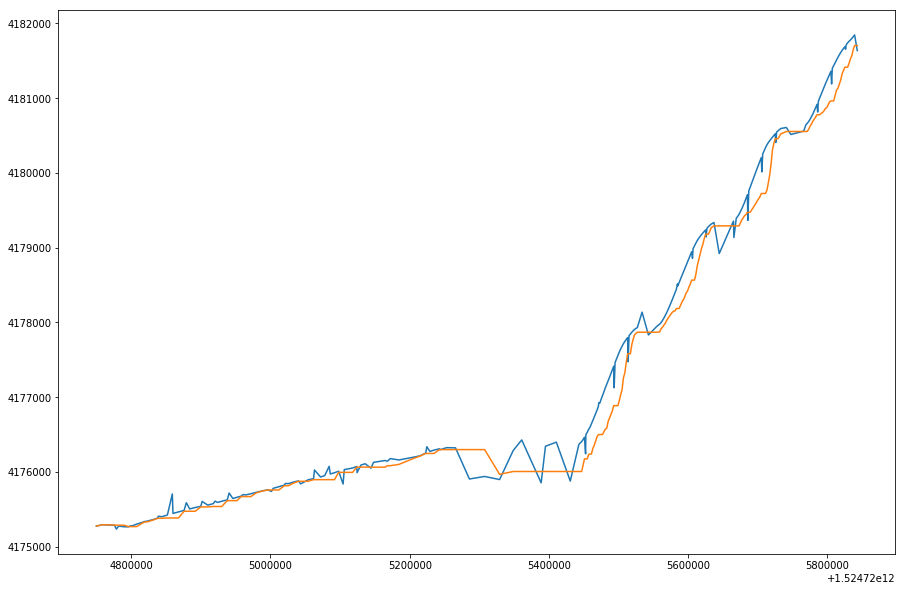

In [25]:
plt.plot(t, x, t, sx)

Аналогичный график для координаты y:

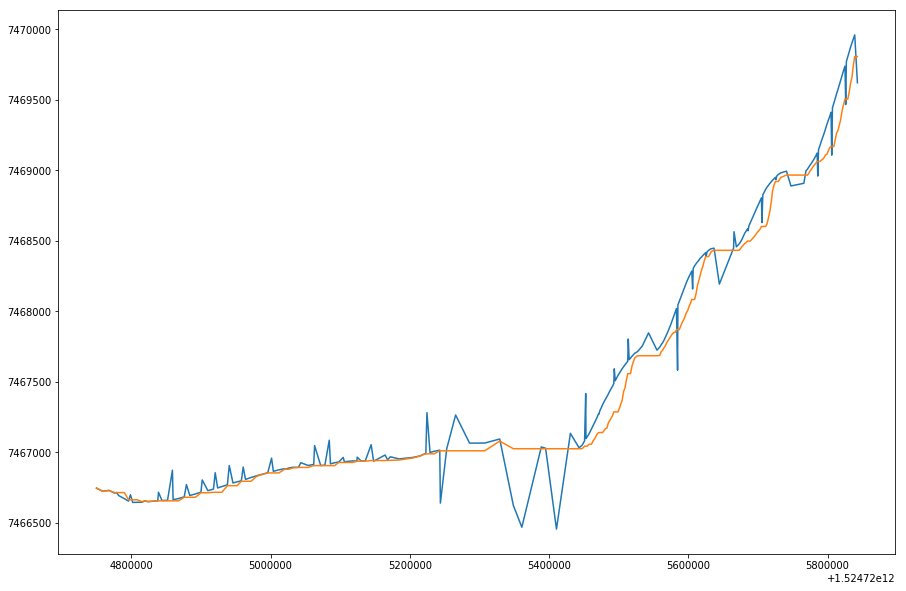

In [26]:
plt.plot(t, y, t, sy)

Построим график сглаженной траектории. Видим, что основная часть шумов была уничтожена, и результат значительно лучше, чем в случае простого экспоненциального сглаживания. Тем не менее не весь шум был очищен - одна петля осталась.

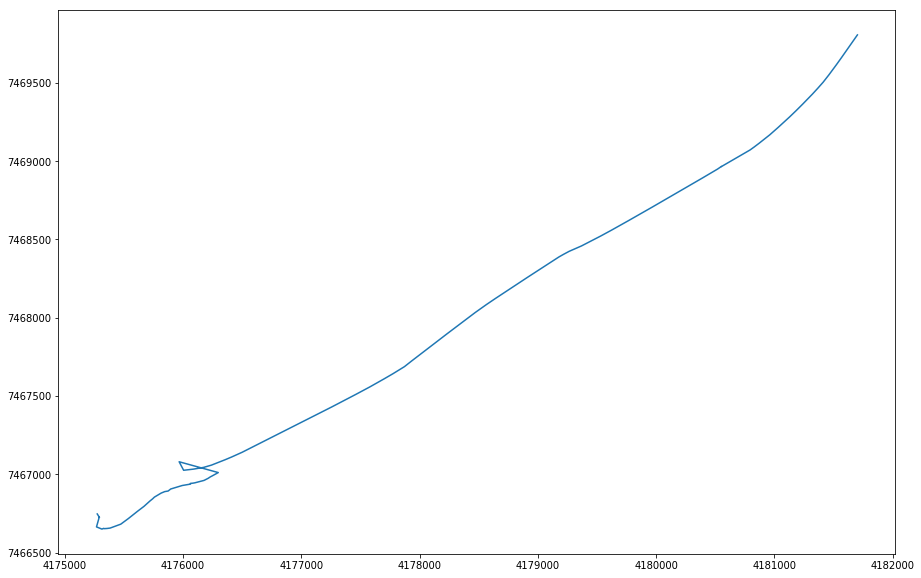

In [27]:
plt.plot(sx, sy)

График исходной траектории и сглаженной:

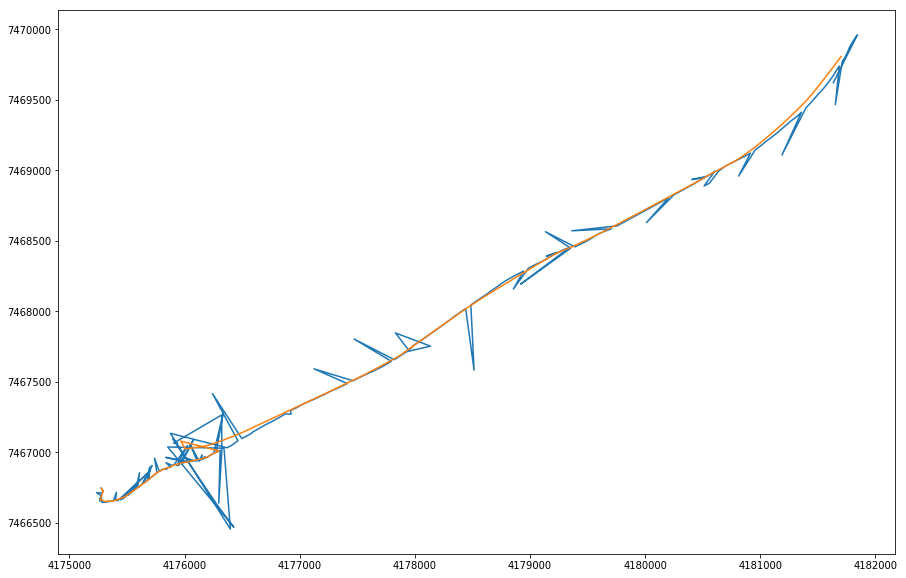

In [28]:
plt.plot(x, y, sx, sy)